<a href="https://colab.research.google.com/github/disenodc/Doctorado_UNS/blob/main/Kernel_Density_Estimate_of_Species_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kernel Density Estimate of Species Distributions

The two species are:

        “Bradypus variegatus” , the Brown-throated Sloth.

        “Microryzomys minutus” , also known as the Forest Small Rice Rat, a rodent that lives in Peru, Colombia, Ecuador, Peru, and Venezuela.

References

        “Maximum entropy modeling of species geographic distributions” S. J. Phillips, R. P. Anderson, R. E. Schapire - Ecological Modelling, 190:231-259, 2006
        #Author: JVanderplas #License: BSD 3 clause

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

In [2]:
# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)



In [4]:
# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)
Xtrain *= np.pi / 180.0  # Convert lat/long to radians


In [5]:
# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


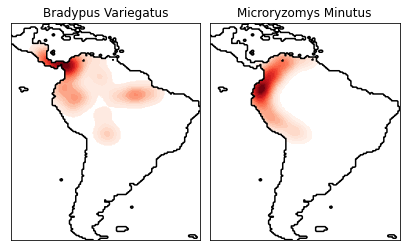

In [6]:
# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()